In [1]:
!pip3 install yahooquery
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 907.3/907.3 KB 24.4 MB/s eta 0:00:00


In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import yfinance as yf

from pprint import pprint
from statsmodels.tsa.arima.model import ARIMA


In [14]:
# select 2 large cap US listed ETFs focusing on APAC equities, and one focused 
# in the US

etf_tickers = [
    "SPY",  # SPDR S&P 500 ETF Trust 
    "VWO",  # Vanguard FTSE Emerging Markets ETF
    "IEMG"  # iShares Core MSCI Emerging Markets ETF
]

In [15]:
start_date = '2017-01-01'
end_date = '2022-12-31'

In [16]:
tickers = {}

In [17]:
for ticker in etf_tickers:
  tickers[ticker] = yf.Ticker(ticker)

In [18]:
histories = {}
for ticker in etf_tickers:
  histories[ticker] = tickers[ticker].history(
      start=start_date,
      end=end_date
  )

In [19]:
histories["VWO"].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2017-01-03 00:00:00-05:00,30.446934,30.623657,30.320701,30.438517,18705200,0.0,0.0,0.0
2017-01-04 00:00:00-05:00,30.623649,30.783544,30.598404,30.716219,19171200,0.0,0.0,0.0
2017-01-05 00:00:00-05:00,30.926606,31.078083,30.918192,31.036007,11923400,0.0,0.0,0.0
2017-01-06 00:00:00-05:00,30.935026,30.960274,30.791965,30.909781,13515300,0.0,0.0,0.0
2017-01-09 00:00:00-05:00,30.876111,30.943436,30.842452,30.859280,14763200,0.0,0.0,0.0


In [22]:
df_price = pd.DataFrame()
for ticker in etf_tickers:
  df_price.loc[:, ticker] = histories[ticker]["Close"]

In [23]:
df_price.head()

,SPY,VWO,IEMG
Date,,,
2017-01-03 00:00:00-05:00,202.856552,30.438517,36.582668
2017-01-04 00:00:00-05:00,204.063385,30.716219,36.906635
2017-01-05 00:00:00-05:00,203.901215,31.036007,37.332897
2017-01-06 00:00:00-05:00,204.630737,30.909781,37.162395
2017-01-09 00:00:00-05:00,203.955292,30.859280,37.077145


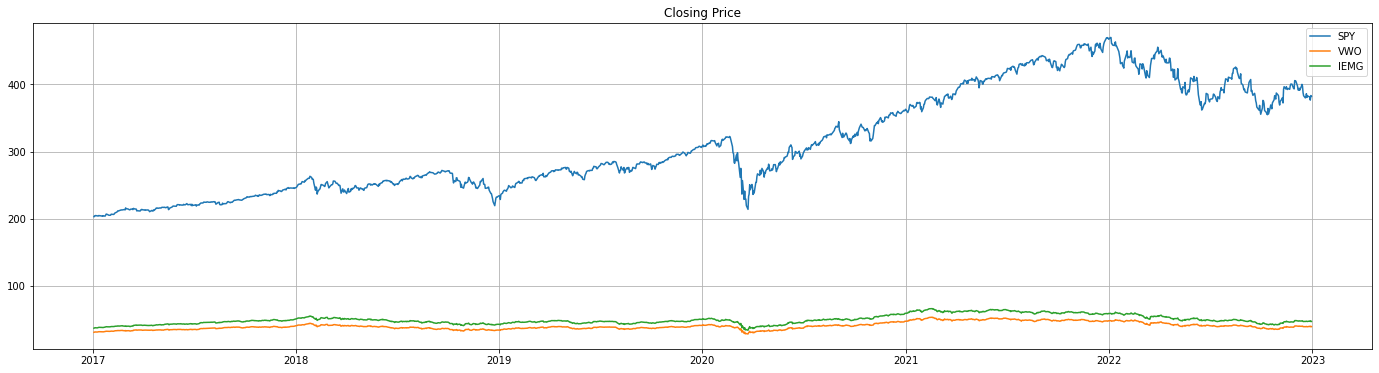

In [37]:
fig, ax = plt.subplots(1, figsize=(24, 6))
ax.set_title("Closing Price")

ax.plot(df_price)
ax.grid()
ax.legend(etf_tickers)

In [41]:
# utils for RSI strategy

# RSI calculations used from https://medium.com/analytics-vidhya/momentum-trading-with-macd-and-rsi-yfinance-python-e5203d2e1a8a

def calculate_rsi(prices: pd.Series) -> pd.DataFrame:
  df = pd.DataFrame(prices)
  col = df.columns[0]

  df['Up Move'] = np.nan
  df['Down Move'] = np.nan
  df['Average Up'] = np.nan
  df['Average Down'] = np.nan
  df['RS'] = np.nan
  df['RSI'] = np.nan

  for x in range(1, len(df)):
    df['Up Move'][x] = 0
    df['Down Move'][x] = 0

    if df[col][x] > df[col][x-1]:
      df['Up Move'][x] = df[col][x] - df[col][x-1]

    if df[col][x] < df[col][x-1]:
      df['Down Move'][x] = abs(df[col][x] - df[col][x-1])

  df['Average Up'][14] = df['Up Move'][1:15].mean()
  df['Average Down'][14] = df['Down Move'][1:15].mean()
  df['RS'][14] = df['Average Up'][14] / df['Average Down'][14]
  df['RSI'][14] = 100 - (100/(1+df['RS'][14]))

  for x in range(15, len(df)):
    df['Average Up'][x] = (df['Average Up'][x-1]*13 + df['Up Move'][x])/14
    df['Average Down'][x] = (df['Average Down'][x-1]*13 + df['Down Move'][x])/14
    df['RS'][x] = df['Average Up'][x] / df['Average Down'][x]
    df['RSI'][x] = 100 - (100/(1+df['RS'][x]))

  return df


In [43]:
def get_strategy_from_rsi(input: pd.DataFrame) -> pd.DataFrame:
  # first column assumed to be prices
  df = pd.DataFrame(input)
  price_col = df.columns[0]

  df['Long Tomorrow'] = np.nan
  df['Buy Signal'] = np.nan
  df['Sell Signal'] = np.nan
  df['Buy RSI'] = np.nan
  df['Sell RSI'] = np.nan
  df['Strategy'] = np.nan

  for x in range(15, len(df)):
    if ((df['RSI'][x] <= 30) & (df['RSI'][x-1] > 30)):
      df['Long Tomorrow'][x] = True

    elif ((df['Long Tomorrow'][x-1] == True) & (df['RSI'][x] <= 70)):
      df['Long Tomorrow'][x] = True

    else:
      df['Long Tomorrow'][x] = False

    if ((df['Long Tomorrow'][x] == True) & (df['Long Tomorrow'][x-1] == False)):
      df['Buy Signal'][x] = df[price_col][x]
      df['Buy RSI'][x] = df['RSI'][x]

    if ((df['Long Tomorrow'][x] == False) & (df['Long Tomorrow'][x-1] == True)):
      df['Sell Signal'][x] = df[price_col][x]
      df['Sell RSI'][x] = df['RSI'][x]

  df['Strategy'][15] = df[price_col][15]

  for x in range(16, len(df)):
    if df['Long Tomorrow'][x-1] == True:
      df['Strategy'][x] = df['Strategy'][x-1] * (df[price_col][x] / df[price_col][x-1])
    else:
      df['Strategy'][x] = df['Strategy'][x-1]

  return df

In [44]:
strategy_rsi = {}

for ticker in etf_tickers:
  rsi = calculate_rsi(df_price[ticker])
  strat = get_strategy_from_rsi(rsi)
  strategy_rsi[ticker] = strat

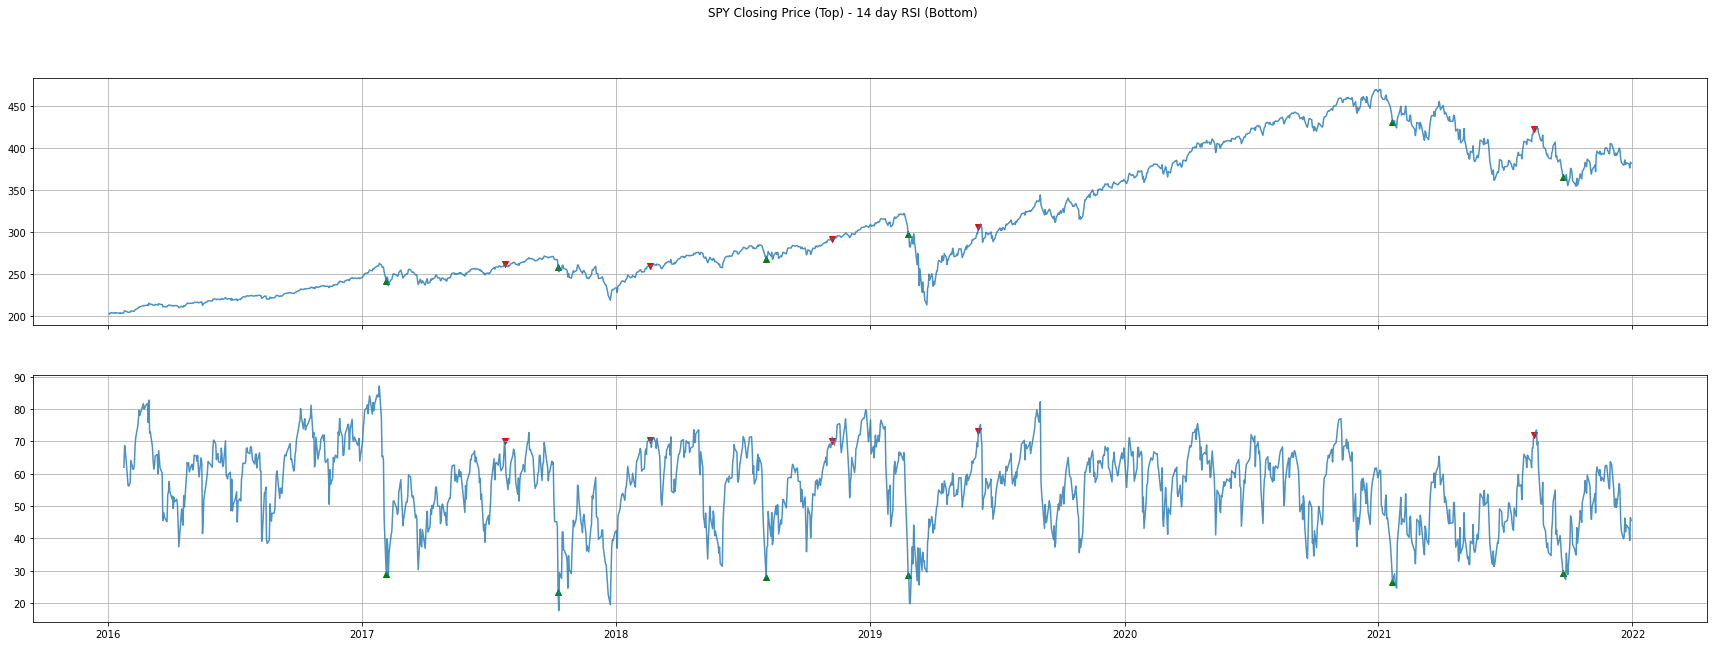

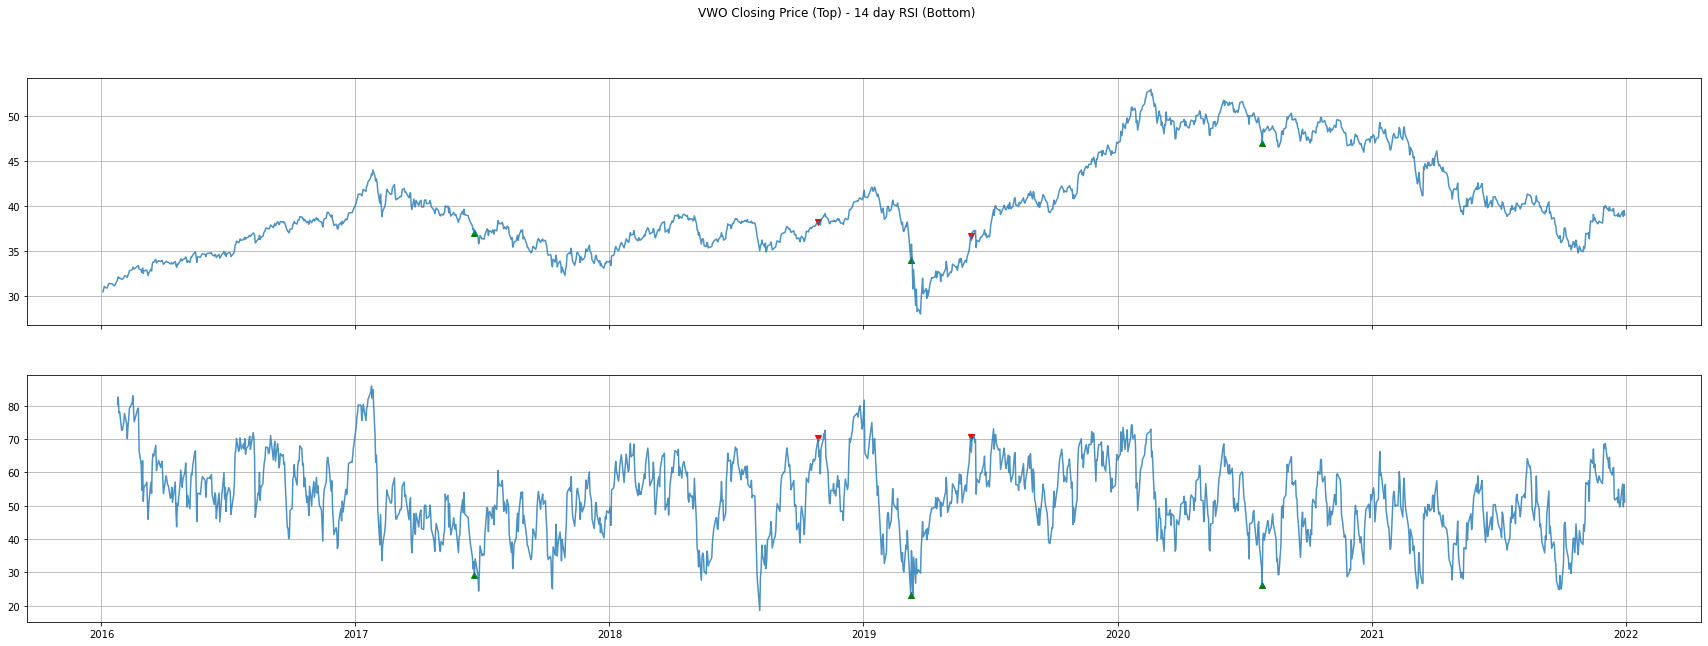

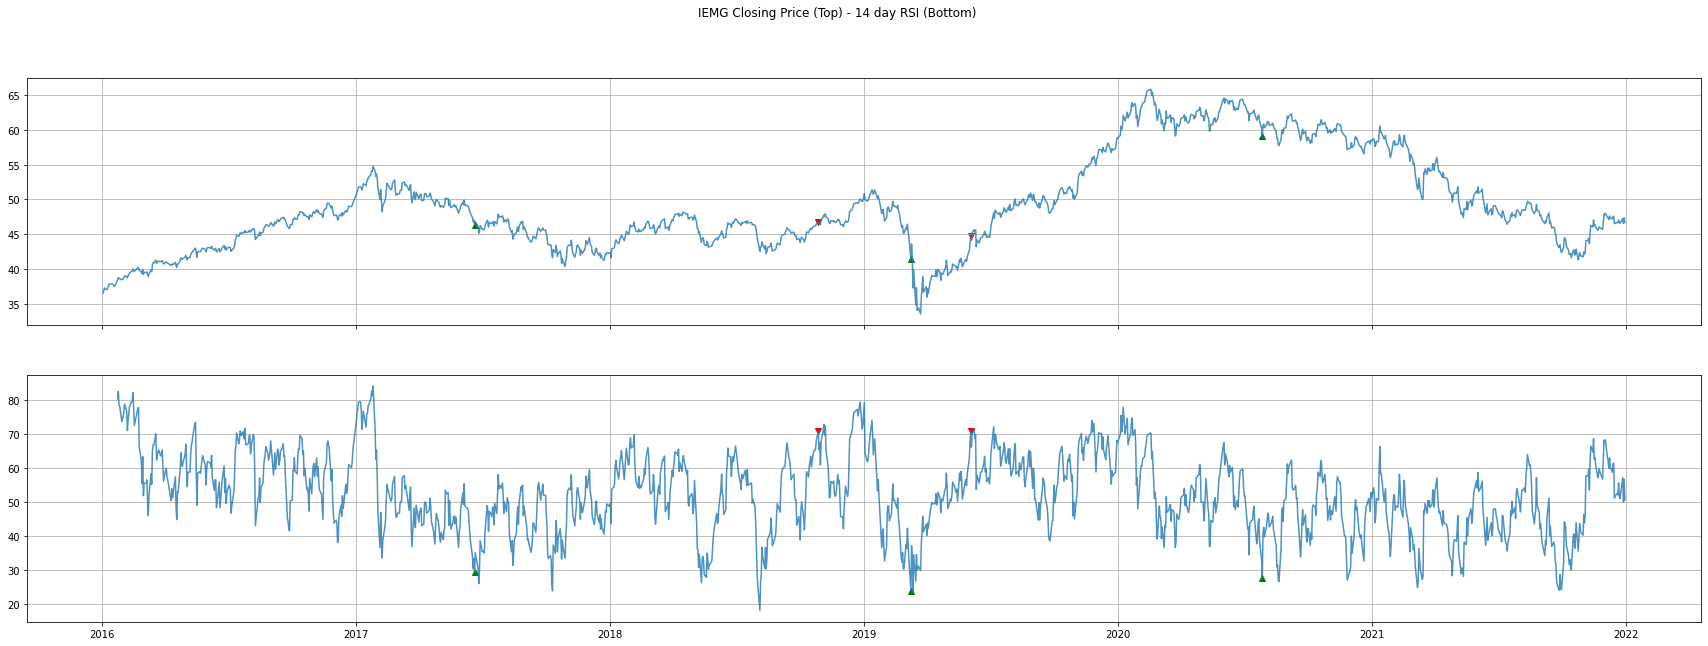

In [48]:
for ticker in etf_tickers:
  fig, axes = plt.subplots(2, sharex=True, figsize=(30, 10))
  fig.suptitle(f"{ticker} Closing Price (Top) - 14 day RSI (Bottom)")

  df = strategy_rsi[ticker]

  axes[0].scatter(
    df.index, 
    df['Buy Signal'], 
    color='green',
    marker='^',
    alpha=1
  )

  axes[0].scatter(
    df.index,
    df['Sell Signal'],
    color='red',
    marker='v',
    alpha=1
  )

  axes[0].plot(df[ticker], alpha=0.8)
  axes[0].grid()

  axes[1].scatter(
    df.index, 
    df['Buy RSI'], 
    color='green',
    marker='^',
    alpha=1
  )

  axes[1].scatter(
    df.index,
    df['Sell RSI'],
    color='red',
    marker='v',
    alpha=1
  )

  axes[1].plot(df['RSI'], alpha=0.8)
  axes[1].grid()


In [59]:
ss = set(strategy_rsi["SPY"]["Buy Signal"].dropna().unique())
ss

{242.3229217529297,
 258.8582763671875,
 268.00103759765625,
 298.0456848144531,
 366.2680969238281,
 430.9879455566406}

In [75]:
trades_rsi = {}

for ticker in etf_tickers:
  df = pd.DataFrame(columns=["ticker", "side", "price"])
  for i, row in strategy_rsi[ticker].iterrows():
    if not np.isnan(row["Buy Signal"]):
      df.loc[i] = [ticker, "BUY", row["Buy Signal"]]
    elif not np.isnan(row["Sell Signal"]):
      df.loc[i] = [ticker, "SELL", row["Sell Signal"]]
  
  trades_rsi[ticker] = df


In [78]:
for ticker in etf_tickers:
  print(trades_rsi[ticker])

                          ticker  side       price
2018-02-05 00:00:00-05:00    SPY   BUY  242.322922
2018-07-25 00:00:00-04:00    SPY  SELL  262.978973
2018-10-10 00:00:00-04:00    SPY   BUY  258.858276
2019-02-19 00:00:00-05:00    SPY  SELL  259.948914
2019-08-05 00:00:00-04:00    SPY   BUY  268.001038
2019-11-07 00:00:00-05:00    SPY  SELL  292.347168
2020-02-25 00:00:00-05:00    SPY   BUY  298.045685
2020-06-05 00:00:00-04:00    SPY  SELL  306.213287
2022-01-21 00:00:00-05:00    SPY   BUY  430.987946
2022-08-12 00:00:00-04:00    SPY  SELL  423.408417
2022-09-23 00:00:00-04:00    SPY   BUY  366.268097
                          ticker  side      price
2018-06-21 00:00:00-04:00    VWO   BUY  36.911407
2019-10-28 00:00:00-04:00    VWO  SELL  38.240101
2020-03-09 00:00:00-04:00    VWO   BUY  34.014400
2020-06-03 00:00:00-04:00    VWO  SELL  36.593372
2021-07-27 00:00:00-04:00    VWO   BUY  47.014210
                          ticker  side      price
2018-06-21 00:00:00-04:00   IEMG   BUY

As a next step, we compute ARIMA models on the price data for each of the ETFs to predict their prices over the period under analysis.

In [87]:
params_df = pd.DataFrame(columns=etf_tickers)
params_df.index.name = "Order"

for i in range(10):
  for j in range(10):
    print(f"Processing order ({i}, {j}, 0)")
    aics = []
    key = f"({i}, {j})"
    for ticker in etf_tickers:
      try:
        tmp_data = pd.DataFrame(df_price[ticker])
        tmp_mdl = ARIMA(tmp_data, order=(i, j, 0)).fit()
        aic = tmp_mdl.aic
        aics.append(aic)
      except Exception as e:
        print(f"{key}: ERROR: \n {e}")
        aics.append(10000000)

    params_df.loc[key] = aics

Processing order (0, 0, 0)
Processing order (0, 1, 0)
Processing order (0, 2, 0)
Processing order (0, 3, 0)
Processing order (0, 4, 0)
Processing order (0, 5, 0)
Processing order (0, 6, 0)
Processing order (0, 7, 0)
Processing order (0, 8, 0)
Processing order (0, 9, 0)
Processing order (1, 0, 0)
Processing order (1, 1, 0)
Processing order (1, 2, 0)
Processing order (1, 3, 0)
Processing order (1, 4, 0)
Processing order (1, 5, 0)
Processing order (1, 6, 0)
Processing order (1, 7, 0)
Processing order (1, 8, 0)
Processing order (1, 9, 0)
Processing order (2, 0, 0)
Processing order (2, 1, 0)
Processing order (2, 2, 0)
Processing order (2, 3, 0)
Processing order (2, 4, 0)
Processing order (2, 5, 0)
Processing order (2, 6, 0)
Processing order (2, 7, 0)
Processing order (2, 8, 0)
Processing order (2, 9, 0)
Processing order (3, 0, 0)
Processing order (3, 1, 0)
Processing order (3, 2, 0)
Processing order (3, 3, 0)
Processing order (3, 4, 0)
Processing order (3, 5, 0)
Processing order (3, 6, 0)
P

We select the based ARMA model based on the minimum AIC value across the models tested

In [88]:
for ticker in etf_tickers:
  print(ticker)
  print(params_df.sort_values(ticker).head())

SPY
                SPY          VWO         IEMG
Order                                        
(9, 1)  8363.545965  2188.424730  2878.336849
(8, 1)  8383.457978  2186.648377  2876.471616
(7, 1)  8395.247366  2187.879705  2878.800665
(9, 0)  8398.631760  2194.404726  2884.888329
(6, 1)  8410.258541  2188.637105  2880.649671
VWO
                SPY          VWO         IEMG
Order                                        
(8, 1)  8383.457978  2186.648377  2876.471616
(7, 1)  8395.247366  2187.879705  2878.800665
(9, 1)  8363.545965  2188.424730  2878.336849
(6, 1)  8410.258541  2188.637105  2880.649671
(2, 1)  8417.415585  2191.001249  2883.978449
IEMG
                SPY          VWO         IEMG
Order                                        
(8, 1)  8383.457978  2186.648377  2876.471616
(9, 1)  8363.545965  2188.424730  2878.336849
(7, 1)  8395.247366  2187.879705  2878.800665
(6, 1)  8410.258541  2188.637105  2880.649671
(2, 1)  8417.415585  2191.001249  2883.978449


Based on the minimum AIC value, the order for the ARMA models for each of the tickers is decided

|Ticker|Order|
|---|---|
|SPY|(9, 1)|
|VWO|(8, 1)|
|IEMG|(8, 1)|


In [90]:
arma_model_orders = {
    "SPY": (9, 1),
    "VWO": (8, 1),
    "IEMG": (8, 1)
}

data_models = {}
for col in arma_model_orders.keys():
  i, j = arma_model_orders[col]
  tmp_data = pd.DataFrame(df_price[col])
  data_models[col] = ARIMA(tmp_data, order=(i, j, 0)).fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [91]:
def plot_ARMA_prices(predictions, actual, title=None):
    fig, ax1 = plt.subplots()
    
    if title:
        fig.suptitle(title, fontsize=16)

    fig.set_figheight(6)
    fig.set_figwidth(14)

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')

    ax1.plot(predictions, color=color)

    color = 'tab:blue'
    ax1.plot(actual, color=color)

    fig.tight_layout()

    fig.legend(['Prediction', 'Actual'], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

    plt.show()

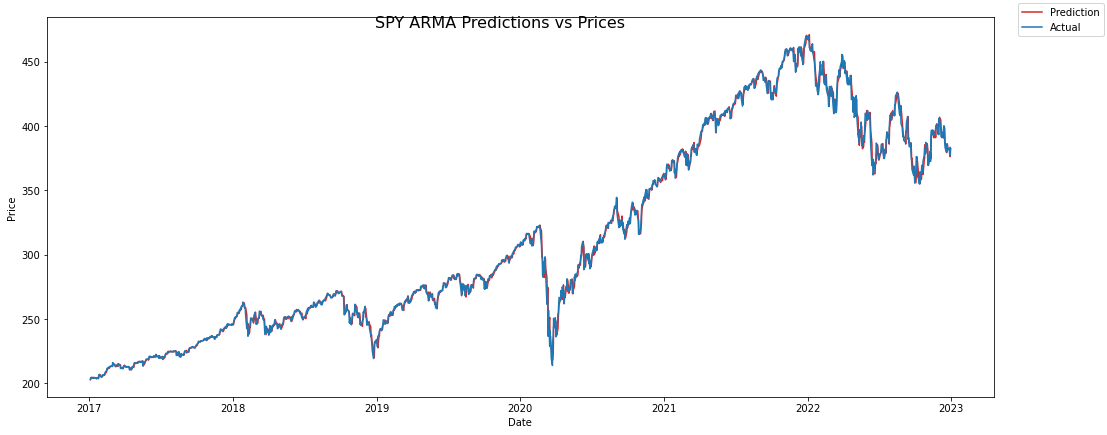

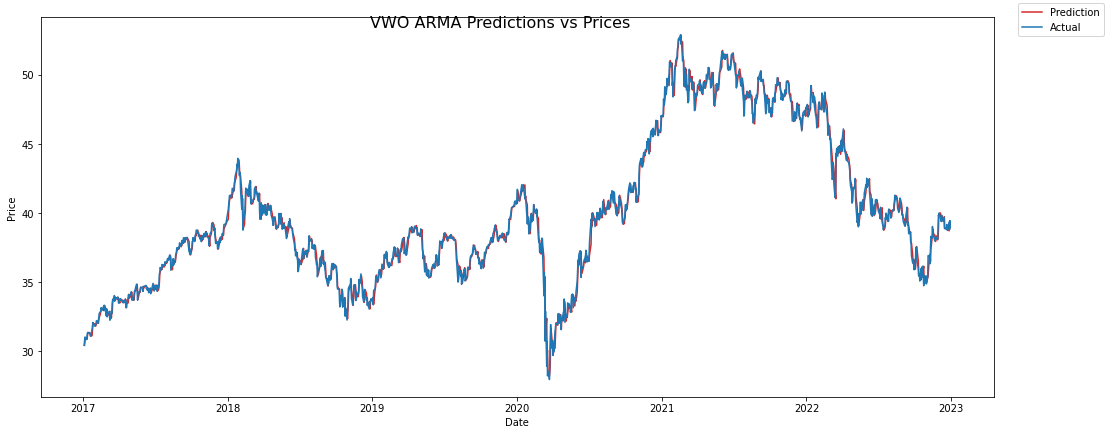

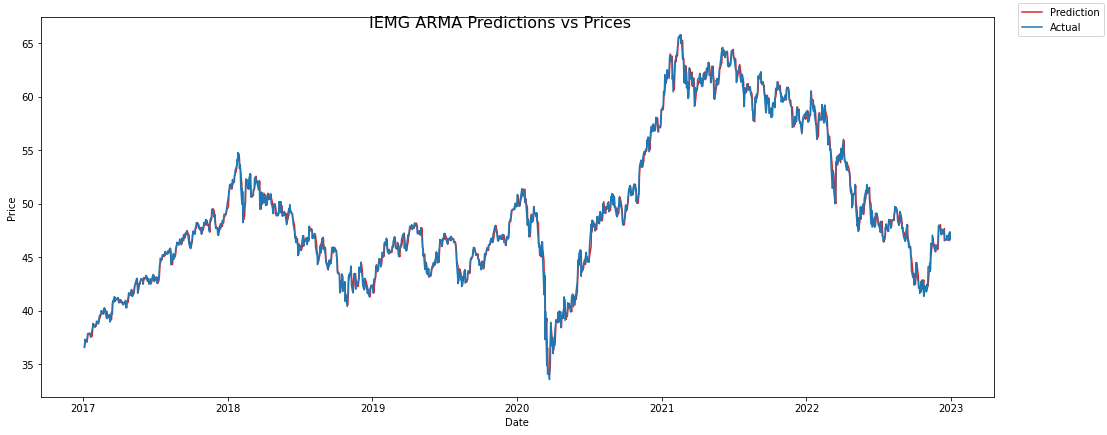

In [92]:
for col in etf_tickers:
  plot_ARMA_prices(data_models[col].predict()[1:], df_price[col], title=f"{col} ARMA Predictions vs Prices")

In [93]:
data_models["SPY"].predict()

Date
2017-01-03 00:00:00-05:00      0.000000
2017-01-04 00:00:00-05:00    202.856240
2017-01-05 00:00:00-05:00    203.944583
2017-01-06 00:00:00-05:00    203.972608
2017-01-09 00:00:00-05:00    204.549892
                                ...    
2022-12-23 00:00:00-05:00    382.074029
2022-12-27 00:00:00-05:00    382.561280
2022-12-28 00:00:00-05:00    381.618123
2022-12-29 00:00:00-05:00    376.171493
2022-12-30 00:00:00-05:00    382.090186
Name: predicted_mean, Length: 1510, dtype: float64